In [1]:
import torchvision.models as models
import torch
from torchvision import transforms
from PIL import Image
from torch.nn.utils.rnn import *
from torch import nn
from torch.utils import data
import time
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
GPU = torch.cuda.is_available()
device = torch.device("cuda" if GPU else "cpu")
cuda = torch.cuda.is_available()
GPU

True

In [3]:
torch.cuda.empty_cache()

### Data Preprocessing

In [4]:
X = []
Y = []
dataType = "center"
numDataPointsWanted = 300 #Might want to change this

transform=transforms.ToTensor()
root_path = "./"
with open(root_path + "labels.txt") as f:
    start = time.time()
    i = 0
    for line in f:
        [filename, radians] = line.split(' ')
        
        if filename[0:4] == "left" and dataType == "left":
            with Image.open(root_path + filename) as img:
                X.append(transform(img.convert('RGB')))
            Y.append(((float(radians) * 180.0)/np.pi))
            i += 1
            
        if filename[0:5] == "right" and dataType == "right":
            with Image.open(root_path + filename) as img:
                X.append(transform(img.convert('RGB')))
            Y.append(((float(radians) * 180.0)/np.pi))
            i += 1
                
        if filename[0:6] == "center" and dataType == "center":
            with Image.open(root_path + filename) as img:
                X.append(transform(img.convert('RGB')))
            Y.append((float(radians) * 180.0)/np.pi)
            i += 1
            
        if i == numDataPointsWanted: break
    end = time.time()
    

print(end - start, "seconds")
print('Images: ', len(X))

5.788816213607788 seconds
Images:  300


# Feature Dataset

In [5]:
import random

context_size = 15

start = time.time()
newX = []
newY = []
for i in range(context_size, len(X)):
    x = [torch.tensor(arr) for arr in X[i-context_size:i]]
    newX.append(torch.stack(x))
    newY.append(Y[i])
    
assert(len(newX) == len(newY))
for i in range(len(newX)-1, 0, -1): 
      
    # Pick a random index from 0 to i  
    j = random.randint(0, i + 1)  
    
    # Swap arr[i] with the element at random index  
    newX[i], newX[j] = newX[j], newX[i]  
    newY[i], newY[j] = newY[j], newY[i]  
    
print(newX[0].shape)
print(newY[0])
train_X, val_X, train_Y, val_Y = train_test_split(newX, newY, test_size=0.20)
end = time.time()
print(end - start, "seconds")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


torch.Size([15, 3, 480, 640])
1.7962460686375405
15.920613050460815 seconds


In [6]:
BATCH_SIZE = 16
num_workers = 0 if cuda else 0 #mem_leak if greater than zero

class Dataset_Model(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index].float(), self.Y[index]
    
train_set = Dataset_Model(train_X, train_Y)
train_dataloader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_set = Dataset_Model(val_X, val_Y)
val_dataloader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

In [7]:
print(len(train_set))
print(len(val_set))

print(train_set.__getitem__(0)[0].shape, train_set.__getitem__(0)[1])

228
57
torch.Size([15, 3, 480, 640]) 0.12420054497436268


# CNN model

In [8]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, input_size, output_size):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=(1, 4, 4), stride=2, padding=2)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=(3, 12, 12), stride=4, padding=2)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv3d(out_channels, out_channels, kernel_size=(1, 4, 4), stride=2, padding=2)
        self.bn3 = nn.BatchNorm3d(out_channels)
        self.relu3 = nn.ReLU()
        
        self.avgpool = nn.AvgPool3d(1)
        
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        output = self.conv1(x) 
        output = self.bn1(output)
        output = self.relu1(output)
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        
        output = self.avgpool(output)
        
        featuresV = output.reshape(output.size(0), -1)
        output = self.fc(featuresV)
        return output

In [9]:
out_channels = 13
input_size = 46800
f_model = CNN(context_size, out_channels, input_size, 1).to(device)
optimizer = torch.optim.Adam(f_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = nn.MSELoss()

print(f_model)

CNN(
  (conv1): Conv3d(15, 13, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(2, 2, 2))
  (bn1): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv3d(13, 13, kernel_size=(3, 12, 12), stride=(4, 4, 4), padding=(2, 2, 2))
  (bn2): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv3d(13, 13, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(2, 2, 2))
  (bn3): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (avgpool): AvgPool3d(kernel_size=1, stride=1, padding=0)
  (fc): Linear(in_features=46800, out_features=1, bias=True)
)


In [10]:
def combine(x, y):
    total = 0
    for v in range(len(x)):
        if x[v] and y[v]:
            total += 1
    return total

In [11]:
def train(num_epochs, model, save):
    EPOCH_TRAIN_LOSSES = []
    EPOCH_VAL_LOSSES = []
    EPOCH_TRAIN_ACC = []
    EPOCH_VAL_ACC = []
    train_a_acc = []
    val_a_acc = []
    
    for epoch in range(num_epochs):
        start = time.time()

        running_train_loss = 0.0
        running_val_loss = 0.0
        train_correct = 0.0
        val_correct = 0.0
        train_total = 0.0
        val_total = 0.0
               
        t_correct_predictions_0_5 = 0.0
        t_correct_predictions_1 = 0.0
        t_correct_predictions_2 = 0.0
        t_correct_predictions_5 = 0.0
        t_correct_predictions_g_5 = 0.0
        
        v_correct_predictions_0_5 = 0.0
        v_correct_predictions_1 = 0.0
        v_correct_predictions_2 = 0.0
        v_correct_predictions_5 = 0.0
        v_correct_predictions_g_5 = 0.0

        model.train()
        for i, (x, label) in enumerate(train_dataloader):
            x, label = x.to(device), label.to(device)
            optimizer.zero_grad()
            y = model(x.float()).double().squeeze(1)
            
            loss = criterion(y, label)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            predicted = y            
            train_correct += torch.sum(torch.abs(predicted - label) < 0.1).item()
            t_correct_predictions_0_5 += torch.sum(torch.abs(predicted - label) <= 0.5).item()
            t_correct_predictions_1 += combine(torch.abs(predicted - label) > 0.5,  torch.abs(predicted - label) <= 1)
            t_correct_predictions_2 += combine(torch.abs(predicted - label) > 1,  torch.abs(predicted - label) <= 2)
            t_correct_predictions_5 += combine(torch.abs(predicted - label) > 2,  torch.abs(predicted - label) <= 5)
            v_correct_predictions_g_5 += torch.sum(torch.abs(predicted - label) > 5).item()
            train_total += label.size(0)
            
            del x
            del label
                    
        train_a_a = [t_correct_predictions_0_5, t_correct_predictions_1, t_correct_predictions_2, t_correct_predictions_5, t_correct_predictions_g_5]
        train_a_acc.append(train_a_a)

        model.eval()
        with torch.no_grad():
            for i, (x, label) in enumerate(val_dataloader):
                x, label = x.to(device), label.to(device)
                y = model(x.float()).double().squeeze(1)
                
                loss = criterion(y, label)

                running_val_loss += loss.item()
                predicted = y
                val_correct += torch.sum(torch.abs(predicted - label) < 0.1).item()
                v_correct_predictions_0_5 += torch.sum(torch.abs(predicted - label) <= 0.5).item()
                v_correct_predictions_1 += combine(torch.abs(predicted - label) > 0.5,  torch.abs(predicted - label) <= 1)
                v_correct_predictions_2 += combine(torch.abs(predicted - label) > 1,  torch.abs(predicted - label) <= 2)
                v_correct_predictions_5 += combine(torch.abs(predicted - label) > 2,  torch.abs(predicted - label) <= 5)
                v_correct_predictions_g_5 += torch.sum(torch.abs(predicted - label) > 5).item()
                val_total += label.size(0)
                
            val_a_a = [v_correct_predictions_0_5, v_correct_predictions_1, v_correct_predictions_2, v_correct_predictions_5, v_correct_predictions_g_5]
            val_a_acc.append(val_a_a)
                
        train_acc = (train_correct / (train_total))*100
        val_acc = (val_correct / (val_total))*100
        tloss = running_train_loss / len(train_dataloader)
        vloss = running_val_loss/ len(val_dataloader)

        print("Epoch", epoch, " Took", int(time.time() - start), "s")
        print("Train Acc:", train_acc, "Val Acc:", val_acc)
        print("Avg Train Loss:", tloss, "Avg Val Loss:", vloss)

        scheduler.step(vloss)

        EPOCH_TRAIN_LOSSES.append(tloss)
        EPOCH_VAL_LOSSES.append(vloss)
        EPOCH_TRAIN_ACC.append(train_acc)
        EPOCH_VAL_ACC.append(val_acc)

        if save:
            torch.save(model.state_dict(), './model_' + str(epoch + 1) + '_' + str(val_acc) + '.pt')
            
    return EPOCH_TRAIN_LOSSES, EPOCH_VAL_LOSSES, EPOCH_TRAIN_ACC, EPOCH_VAL_ACC, val_a_acc, train_a_acc

In [12]:
n_epochs = 9
t_l, v_l, t_a, v_a, val_a_acc, train_a_acc = train(n_epochs, f_model, save=False)

Epoch 0  Took 152 s
Train Acc: 7.456140350877193 Val Acc: 5.263157894736842
Avg Train Loss: 10.797240570361266 Avg Val Loss: 11.746989679030598
Epoch 1  Took 154 s
Train Acc: 2.631578947368421 Val Acc: 3.508771929824561
Avg Train Loss: 9.48928658944214 Avg Val Loss: 9.935610321486266
Epoch 2  Took 120 s
Train Acc: 3.070175438596491 Val Acc: 7.017543859649122
Avg Train Loss: 9.279986625927284 Avg Val Loss: 8.505250833929336
Epoch 3  Took 112 s
Train Acc: 2.631578947368421 Val Acc: 3.508771929824561
Avg Train Loss: 8.376677352779414 Avg Val Loss: 7.244935153354794
Epoch 4  Took 118 s
Train Acc: 2.631578947368421 Val Acc: 8.771929824561402
Avg Train Loss: 8.178263004452196 Avg Val Loss: 6.332970660148606
Epoch 5  Took 161 s
Train Acc: 5.263157894736842 Val Acc: 7.017543859649122
Avg Train Loss: 8.197319113262555 Avg Val Loss: 6.022727112494323
Epoch 6  Took 106 s
Train Acc: 2.1929824561403506 Val Acc: 0.0
Avg Train Loss: 8.099734971492872 Avg Val Loss: 5.693735582690603
Epoch 7  Took 111 

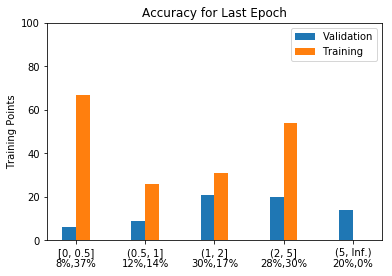

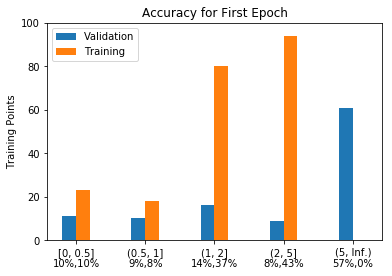

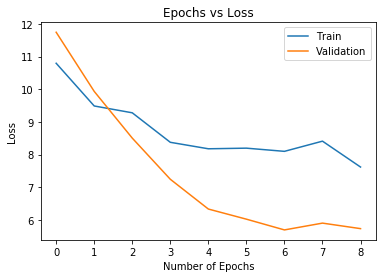

In [26]:
import matplotlib.pyplot as plt

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[-1]
performanceT = train_a_acc[0]

x = np.arange(len(objects))
# print(v_all_a)
width = 0.2 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for Last Epoch')
ax.set_xticks(x)
plt.ylim(0, 100)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
plt.savefig('Last_Epoch.png', dpi=300)

plt.show()

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[0]
performanceT = train_a_acc[-1]

x = np.arange(len(objects))
# print(v_all_a)
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for First Epoch')
ax.set_xticks(x)
plt.ylim(0, 100)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
plt.savefig('Zero_Epoch.png', dpi=300)

plt.show()

x = np.arange(n_epochs)

rangeVi = 0
rangeVf = 9
plt.plot(x[rangeVi:rangeVf], t_l[rangeVi:rangeVf], label="Train")
plt.plot(x[rangeVi:rangeVf], v_l[rangeVi:rangeVf], label="Validation")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.savefig('CNN3dLossFinal.png')
plt.show()